In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from numba import cuda
import numba
import time
import multiprocessing as mp
from tqdm import tqdm
from scipy.stats import linregress
from scipy.optimize import curve_fit
import matplotlib.font_manager as font_manager

In [2]:
@jit(nopython = True)
def decide_interact_neuron_square(neuron_row, neuron_column, neuron_number_row, neuron_number_column):
    if (neuron_row - 1 < 0):
        left = [neuron_number_row -1, neuron_column]
    else:
        left = [neuron_row - 1, neuron_column]
    
    if (neuron_row + 1 == neuron_number_row):
        right = [0, neuron_column]
    else:
        right = [neuron_row + 1, neuron_column]
        
    if (neuron_column + 1 == neuron_number_column):
        up = [neuron_row, 0]
    else:
        up = [neuron_row, neuron_column + 1]
        
    if (neuron_column - 1 < 0):
        down = [neuron_row, neuron_number_column -1]
    else:
        down = [neuron_row, neuron_column - 1]
        
    return np.array([left, down, right, up])

@jit(nopython = True)
def create_square_lattice_link(row_number, column_number, sigma):
    square_lattice = np.zeros((row_number, column_number, 4, 2))
    p_max = 2*sigma/4
    flag = np.zeros((row_number, column_number , 4))
    link = np.zeros((row_number, column_number, 4))
    for row in range(row_number):
        for column in range(column_number):
            square_lattice[row][column][:] = decide_interact_neuron_square(row, column, row_number, column_number)[:]
            for i in range(4):
                if (flag[row][column][i] == 0):
                    random = p_max/2
#                     random = np.random.random() * p_max
                    link[row][column][i] = random
                    r, c = square_lattice[row][column][i]
                    link[int(r)][int(c)][int((i+2)%4)] = random
                    flag[row][column][i] = 1
                    flag[int(r)][int(c)][int((i+2)%4)] = 1
                    
    return square_lattice, link

In [3]:
###   external stimulus   ###
@jit(nopython = True)
def external_arr(t_min, t_max, t, r):
    if t_min <= t < t_max:
        return (1 - np.exp(-r))
    else:
        return np.zeros(r.shape)

###   internal(neural) stimulus   ###
@jit(nopython = True)
def internal_arr(p, index_matrix, state_matrix, state_number, degree):
    probability = np.zeros((state_matrix.shape))
    for row in range(state_matrix.shape[0]):
        for column in range(state_matrix.shape[1]):
            for i in range (int(degree[row][column])) :
                r, c = index_matrix[row][column][i]
#                 if (state_matrix[int(r)][int(c)] == 1):
                if (state_matrix[int(r)][int(c)] ==(state_number - 1) ):
                    probability[row][column] = 1 - (1 - p[row][column][i]) * (1 - probability[row][column])
    return probability

###   determine the activity   ###
@jit(nopython = True)
def rho_determine(state_matrix, state_number):
    row_number = state_matrix.shape[0]
    column_number = state_matrix.shape[1]
    fire = 0
    for row in range(row_number):
#         active = [i for i, v in enumerate(state_matrix[row]) if v==1]
        active = [i for i, v in enumerate(state_matrix[row]) if v == (state_number - 1)]
        fire += len(active)
    return fire/(state_matrix.shape[0]*state_matrix.shape[1])

###   determine the average activity   ###
@jit(nopython = True)
def F0_determine(rho, T_min = 0, T_max = 1000):
    return rho[T_min:T_max].sum()/rho[T_min:T_max].size

In [4]:
@jit(nopython = True)
def KC_model(degree, index_matrix, p, t_min, stimulas_t, stimulas_S, MC_times, state_number, noise_r = 0):
    
    ###   Initialization start   ###
    rho = np.zeros(MC_times)
    row_number = p.shape[0]
    column_number = p.shape[1]
    state_matrix = np.random.randint(0, state_number, (row_number, column_number))
#     state_matrix = np.zeros((row_number, column_number))
    rho[0] = rho_determine(state_matrix, state_number)
    temp = np.copy(state_matrix)
    
        
    ###   Monte Carlo   ###
    for t in range(1, MC_times):
        internal = internal_arr(p, index_matrix, state_matrix, state_number, degree)
        noise_array = 1 - np.exp(-np.random.random(size = (row_number, column_number)) * noise_r)
        
        ###   update states among per row direction   ###
        for r in range (row_number):
            
            ###   Update refractory state   ###
            loc = np.where((state_matrix[r]>0)&(state_matrix[r]<(state_number)))
            temp[r][loc] -= 1 
            
            ###   Locate the excitable neurons   ###
            location_0 = np.where(state_matrix[r] == 0)
            probability = np.zeros(column_number)
            probability[location_0] = 1 -  ((1 - internal[r][location_0]) * (1 - noise_array[r][location_0])*\
                                        (1 - external_arr(t_min, stimulas_t, t, stimulas_S[r][location_0])))
            
             ###   determine the process from resting to firing   ###
            random = np.random.random(column_number)
            temp[r][np.where(random < probability)] = state_number - 1
            
        state_matrix = np.copy(temp)
        rho[t] = rho_determine(state_matrix, state_number)
    return rho

Time cost: 32.71512246131897


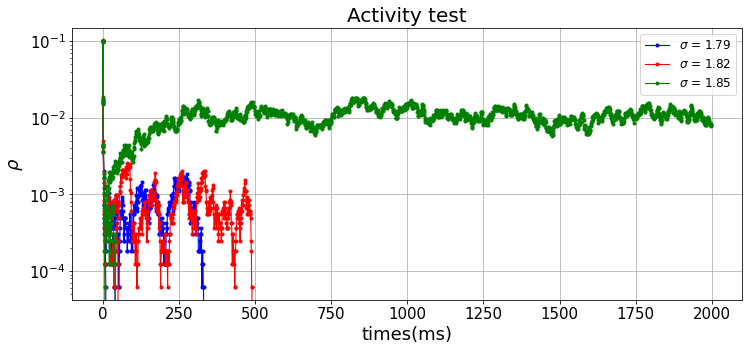

In [5]:
row = 128
column = 128
states_num = 10
color = ['blue', 'red', 'green']
r_list = [10**(-5), 10**(-6)]
sigma_list = [1.79, 1.82, 1.85]
times = 2000
fig, ax = plt.subplots(figsize=(12, 5))
t_test = np.arange(times)
start_i = time.time()
for i in range (9):
    sigma = sigma_list[i//3]
#     sigma = 1.9
    degree = np.ones((row, column))*4
    network_connection, p  = create_square_lattice_link(row,column,sigma)
    r = 0 #r_list[i]
    r_array = np.ones((row, column)) * r 
    rho_test = KC_model(degree, network_connection, p, 0, times, r_array, times, states_num)
    if(i%3):
        ax.plot(t_test[0:], rho_test[0:],'.' , linewidth=1.1, color = color[i//3], linestyle='-')
    else:
        ax.plot(t_test[0:], rho_test[0:],'.' , linewidth=1.1, color = color[i//3], linestyle='-', label = '$\sigma$ = %.2f'%sigma)
print('Time cost:', time.time()-start_i)
ax.set_yscale('log')
ax.set_xlabel('times(ms)',fontsize=18)
ax.set_ylabel('$\\rho$',fontsize=18)
# ax.set_title('n= %d, row = %d, col = %d'%(states_num, row, column),fontsize=20)
ax.set_title('Activity test',fontsize=20)
# ax.set_yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
font_prop = font_manager.FontProperties(size=12)
ax.legend(prop = font_prop)
plt.grid()

In [6]:
@jit(nopython = False)
def FSS(r0, r1, L, sigma_begin):
    """Finite-size scaling"""
    Delta = []
    row = L
    column = L
    state_number = 10
    times = 1500
    for sigma in range(0, 5):
        degree = np.ones((row, column))*4
        network_connection, p  = create_square_lattice_link(row,column,(sigma / 25) + sigma_begin)
        r0_array =  np.ones((row, column)) * r0
        r1_array =  np.ones((row, column)) * r1
        rho_test_r = KC_model(degree, network_connection, p, 0, times,r0_array, times, state_number, noise_r=0)
        rho_test_zero = KC_model(degree, network_connection, p, 0, times, r1_array, times, state_number, noise_r=0)
        F0_r_ = F0_determine(rho_test_r, T_min = 500, T_max = times)
        F0_zero_ = F0_determine(rho_test_zero, T_min = 500, T_max = times)
        Delta.append((F0_r_ - F0_zero_)/(r0 - r1))
        
    for sigma in range(0, 25):
        degree = np.ones((row, column))*4
        network_connection, p  = create_square_lattice_link(row,column,(sigma / 250) + sigma_begin + 0.2)
        r0_array =  np.ones((row, column)) * r0
        r1_array =  np.ones((row, column)) * r1
        rho_test_r = KC_model(degree, network_connection, p, 0, times,r0_array, times, state_number, noise_r=0)
        rho_test_zero = KC_model(degree, network_connection, p, 0, times, r1_array, times, state_number, noise_r=0)
        F0_r_ = F0_determine(rho_test_r, T_min = 500, T_max = times)
        F0_zero_ = F0_determine(rho_test_zero, T_min = 500, T_max = times)
        Delta.append((F0_r_ - F0_zero_)/(r0 - r1))
        
    for sigma in range(0, 6):
        degree = np.ones((row, column))*4
        network_connection, p  = create_square_lattice_link(row,column,(sigma / 50) + sigma_begin + 0.3)
        r0_array =  np.ones((row, column)) * r0
        r1_array =  np.ones((row, column)) * r1
        rho_test_r = KC_model(degree, network_connection, p, 0, times,r0_array, times, state_number, noise_r=0)
        rho_test_zero = KC_model(degree, network_connection, p, 0, times, r1_array, times, state_number, noise_r=0)
        F0_r_ = F0_determine(rho_test_r, T_min = 500, T_max = times)
        F0_zero_ = F0_determine(rho_test_zero, T_min = 500, T_max = times)
        Delta.append((F0_r_ - F0_zero_)/(r0 - r1))
    return Delta

@jit(nopython = False)
def multi_compute_FSS(r0_r1_L_sigma):
    r0, r1, L, sigma_begin = r0_r1_L_sigma[0], r0_r1_L_sigma[1], r0_r1_L_sigma[2], r0_r1_L_sigma[3]
    Delta = FSS(r0, r1, int(L), sigma_begin)
    return Delta

In [ ]:
pool = mp.Pool(processes = 12)
FSS_test = []
L_banch = [400]
e_banch = [60]
sigma_begin_banch = [1.545]
start_i = time.time()
with mp.Pool(processes = 12) as pool:
    for i in range(len(L_banch)):
        with tqdm(total=e_banch[i]) as pbar:
            test_banch = np.array([[2*10**(-5), 10**(-5), L_banch[i], sigma_begin_banch[i] ]for j in range(e_banch[i])])
            result = []
            for k, a in enumerate(pool.imap_unordered(multi_compute_FSS, test_banch)):
                result.append(a)
                pbar.update(1)
            FSS_test.append(result)
            print('L:', L_banch[i], 'finished')
print('Time cost:', time.time()-start_i)

 60%|██████    | 36/60 [1:55:09<09:45, 24.40s/it]   

In [ ]:
FSS_test = np.array(FSS_test)
ensemble_FSS_test = []

for i in range(FSS_test.shape[0]):
    ensemble_Delta = np.zeros(FSS_test.shape[2])
    
    for j in range(FSS_test.shape[2]):
        
        for k in range(FSS_test.shape[1]):
            ensemble_Delta[j] += FSS_test[i][k][j]/FSS_test.shape[1]
            
    ensemble_FSS_test.append(ensemble_Delta)

In [20]:
print(len(ensemble_FSS_test[0]))

36


IndexError: list index out of range

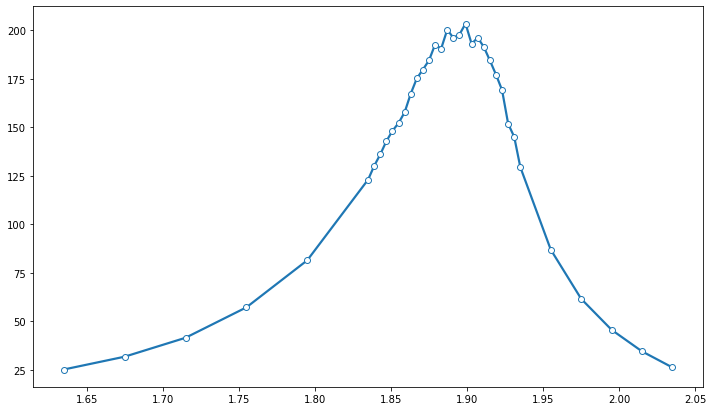

In [18]:
test_banch = []
for L in range(len(L_banch)):
    test_banch.append([(i / 25) + sigma_begin_banch[L] for i in range(5)])
    for i in range(25):
        test_banch[L].append(i/250 + sigma_begin_banch[L]+ 0.2)
    for i in range(6): 
        test_banch[L].append(i/50 + sigma_begin_banch[L]+ 0.3)
    
    
fig, ax = plt.subplots(figsize=(12, 7))
for L in range(len(L_banch)):
    ax.plot(test_banch[L], ensemble_FSS_test[L], linewidth=2.2, linestyle='-', marker = 'o'\
            , mfc='w', label = 'L = %d'%(L_banch[L]))

ax.set_xlabel('$\sigma$',fontsize=27)
ax.set_ylabel('$\chi / L^2$',fontsize=27, rotation = 0)
# ax.set_title('FSS of KCNN ($r_0 = 10^{-5}$, $r_1 = 2*10^{-5}$, n = 4)',fontsize=32)
ax.tick_params(axis='x', colors = 'black',  which='major', labelsize=20)
ax.tick_params(axis='y', colors = 'black',  which='major', labelsize=20)
ax.yaxis.set_label_coords(-0.01,1.02)
ax.xaxis.set_label_coords(1.02,-0.02)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
font_prop = font_manager.FontProperties(size=18)
ax.legend(prop = font_prop)

plt.grid()

In [ ]:
FSS_test_all = (np.load('FSS_KCNN_25_600_modify_n10_PBC.npy', allow_pickle=True))
L_banch = (np.load('FSS_KCNN_25_600_modify_n10_PBC_L.npy', allow_pickle=True))
sigma_begin_banch = (np.load('FSS_KCNN_25_600_modify_n10_PBC_sigma.npy', allow_pickle=True))

In [ ]:
FSS_test_all = np.array(FSS_test_all)
ensemble_FSS_Delta = []
for i in range(len(L_banch)):
    ensemble_Delta = np.zeros(np.array(FSS_test_all[i]).shape[1])
    for j in range(np.array(FSS_test_all[i]).shape[1]):
        for k in range(len(FSS_test_all[i])):
            ensemble_Delta[j] += FSS_test_all[i][k][j]/len(FSS_test_all[i])
    ensemble_FSS_Delta.append(ensemble_Delta)

In [ ]:
test_banch = []
for L in range(len(L_banch)):
    test_banch.append([(i / 25) + sigma_begin_banch[L] for i in range(5)])
    for i in range(25):
        test_banch[L].append(i/250 + sigma_begin_banch[L]+ 0.2)
    for i in range(6): 
        test_banch[L].append(i/50 + sigma_begin_banch[L]+ 0.3)
    
    
fig, ax = plt.subplots(figsize=(12, 7))
for L in range(len(L_banch)):
# loc = 5
# for L in range(loc, loc+1):
    ax.plot(test_banch[L], ensemble_FSS_Delta[L], linewidth=2.2, linestyle='-', marker = 'o'\
            , mfc='w', label = 'L = %d'%(L_banch[L]))

ax.set_xlabel('$\sigma$',fontsize=27)
ax.set_ylabel('$\chi / L^2$',fontsize=27, rotation = 0)
# ax.set_title('FSS of KCNN ($r_0 = 10^{-5}$, $r_1 = 2*10^{-5}$, n = 4)',fontsize=32)
ax.tick_params(axis='x', colors = 'black',  which='major', labelsize=20)
ax.tick_params(axis='y', colors = 'black',  which='major', labelsize=20)
ax.yaxis.set_label_coords(-0.01,1.02)
ax.xaxis.set_label_coords(1.02,-0.02)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
font_prop = font_manager.FontProperties(size=18)
ax.legend(prop = font_prop)

plt.grid()

In [ ]:
###   Find maximum(critical point) of system   ###
FSS_critical = []
test_banch = np.array(test_banch)
for i in range(len(ensemble_FSS_Delta)):
    FSS_temp_arr = ensemble_FSS_Delta[i]
    FSS_critical.append(test_banch[i][np.where(FSS_temp_arr == FSS_temp_arr.max())][0])
print(FSS_critical)

In [ ]:
###   Fitting   ###
def objective_length(x, a, b, c):
	return a*x**(-1/b) + c
popt, _ = curve_fit(objective_length, L_banch[0:], FSS_critical[0:])
a, b, c = popt
fig, ax = plt.subplots(figsize=(10, 6))
print('const:', a, '\mu:', b, 'T_c:', c)

###   plot data point   ###
plt.scatter(1/L_banch, FSS_critical)

###   calculate the output for the range and fitting   ###
x_line = np.arange(min(L_banch), max(L_banch), 1)
y_line = np.array(objective_length(x_line, a, b, c))

ax.set_xlabel('$1/L$',fontsize=25)
ax.set_ylabel('$\sigma_c$',fontsize=27, rotation = 0)
# ax.set_title('FSS of KCNN ($r_0 = 10^{-5}$, $r_1 = 2*10^{-5}$, n = 14)',fontsize=20)
plt.plot(1/x_line,y_line, '-', linewidth=2, color='red')

ax.yaxis.set_label_coords(-0.01,1.02)
ax.xaxis.set_label_coords(1.06,-0.02)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
font_prop = font_manager.FontProperties(size=18)
# plt.show()
plt.grid()

In [ ]:
KCNN_transition = [1.14, 1.592, 1.720, 1.771, 1.804, 1.824, 1.836, 1.846] 
poor_man_qt = ([float("{:.3f}".format(4/((2**(2*i+1) - 4)**(1/(2*i-1))))) for i in range(1, len(KCNN_transition)+1)])
poor_man_qt_cont = ([4/((2**(2*kx/100+1) - 4)**(1/(2*kx/100-1))) for kx in range(100, len(KCNN_transition)*100+1)])
banch = [2*i for i in range(1, len(poor_man_qt)+1)]
banch_cont = [2*i/100 for i in range(100, len(poor_man_qt_cont)+100)]

fig, ax = plt.subplots(figsize=(12, 7))
# ax.scatter(banch[0:], poor_man_qt[0:], linewidth=2.2, linestyle='-', marker = 'o'\
#             , color = 'red', label = 'Poor man')

ax.plot(banch_cont[0:], poor_man_qt_cont[0:], linewidth=3, linestyle='-', color = 'red', label = 'Poor man\'s scaling')
# for a, b in zip(banch, poor_man_qt):
#     plt.text(a, b, b, ha='right', va='bottom', fontsize=18, color = 'red')


ax.plot(banch[0:], KCNN_transition[0:], linewidth=3, linestyle='-', marker = 'o'\
            , mfc='w', color = 'blue', label = 'Simulation')

# for a, b in zip(banch, KCNN_transition):
#     plt.text(a, b, b, ha='right', va='bottom', fontsize=18, color = 'blue')

ax.set_ylabel('$\sigma_c$',fontsize=27)
ax.set_xlabel('total state number $n$',fontsize=27)
ax.set_title('KCNN critical branching ratio',fontsize=28)
# ax.set_title('KCNN transition point ($\sigma_c$) (L = 256, r = $10^{-7}$)',fontsize=28)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# ax.set_yscale('log')
font_prop = font_manager.FontProperties(size=18)
ax.legend(prop = font_prop, loc = 4)
plt.grid()